# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [2]:
! apt-get update
! apt-get install -y --no-install-recommends g++ gcc

Ign:1 http://deb.debian.org/debian stretch InRelease
Get:2 http://security.debian.org/debian-security stretch/updates InRelease [53.0 kB]
Get:3 http://deb.debian.org/debian stretch-updates InRelease [93.6 kB]
Get:4 http://deb.debian.org/debian stretch Release [118 kB]          
Get:5 http://deb.debian.org/debian stretch Release.gpg [2410 B]
Get:6 http://security.debian.org/debian-security stretch/updates/main amd64 Packages [653 kB]
Get:7 http://deb.debian.org/debian stretch-updates/main amd64 Packages.diff/Index [14.5 kB]
Get:8 http://deb.debian.org/debian stretch-updates/main amd64 Packages [2596 B]
Get:9 http://deb.debian.org/debian stretch/main amd64 Packages [7080 kB]       
Fetched 8017 kB in 2s (3546 kB/s)   
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binutils cpp cpp-6 g++-6 gcc-6 libasan3 libatomic1 libc-dev-bin libc6-dev
  libcc1-0 libcilkr

Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../22-libc6-dev_2.24-11+deb9u4_amd64.deb ...
Unpacking libc6-dev:amd64 (2.24-11+deb9u4) ...
Selecting previously unselected package libstdc++-6-dev:amd64.
Preparing to unpack .../23-libstdc++-6-dev_6.3.0-18+deb9u1_amd64.deb ...
Unpacking libstdc++-6-dev:amd64 (6.3.0-18+deb9u1) ...
Selecting previously unselected package g++-6.
Preparing to unpack .../24-g++-6_6.3.0-18+deb9u1_amd64.deb ...
Unpacking g++-6 (6.3.0-18+deb9u1) ...
Selecting previously unselected package g++.
Preparing to unpack .../25-g++_4%3a6.3.0-4_amd64.deb ...
Unpacking g++ (4:6.3.0-4) ...
Setting up libquadmath0:amd64 (6.3.0-18+deb9u1) ...
Setting up libgomp1:amd64 (6.3.0-18+deb9u1) ...
Setting up libatomic1:amd64 (6.3.0-18+deb9u1) ...
Setting up libcc1-0:amd64 (6.3.0-18+deb9u1) ...
Setting up libasan3:amd64 (6.3.0-18+deb9u1) ...
Setting up libcilkrts5:amd64 (6.3.0-18+deb9u1) ...
Setting up libubsan0:amd64 (6.3.0-18+deb9u1) ...
Setting up lib

In [3]:
! pip install shap==0.37.0 slicer==0.0.3 xgboost==1.3.0.post0

    100% |████████████████████████████████| 327kB 9.7MB/s ta 0:00:011
    100% |████████████████████████████████| 157.5MB 104kB/s eta 0:00:01 day, 23:57:12                       | 2.7MB 9.0MB/s eta 0:00:18    42% |█████████████▌                  | 66.6MB 21.8MB/s eta 0:00:05    44% |██████████████▏                 | 69.6MB 10.7MB/s eta 0:00:09    44% |██████████████▍                 | 70.6MB 11.2MB/s eta 0:00:08    45% |██████████████▌                 | 71.2MB 12.0MB/s eta 0:00:08    46% |███████████████                 | 73.6MB 11.5MB/s eta 0:00:08    47% |███████████████                 | 74.1MB 10.8MB/s eta 0:00:08    50% |████████████████                | 78.8MB 12.1MB/s eta 0:00:07    50% |████████████████▏               | 79.4MB 10.9MB/s eta 0:00:08    51% |████████████████▍               | 80.5MB 17.7MB/s eta 0:00:05    51% |████████████████▌               | 81.1MB 11.3MB/s eta 0:00:07    55% |██████████████████              | 88.1MB 11.1MB/s eta 0:00:07    62% |████████████████

In [4]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [5]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [6]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="../data_dir"

In [7]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


In [8]:
for k in inputs.keys():
    print(k)
    print(dfs[k].info())
    print(dfs[k].head(1).T)

stock_list
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 14 columns):
prediction_target                            3711 non-null bool
Effective Date                               3711 non-null int64
Local Code                                   3711 non-null int64
Name (English)                               3711 non-null object
Section/Products                             3711 non-null object
33 Sector(Code)                              3711 non-null int64
33 Sector(name)                              3711 non-null object
17 Sector(Code)                              3711 non-null int64
17 Sector(name)                              3711 non-null object
Size Code (New Index Series)                 3711 non-null object
Size (New Index Series)                      3711 non-null object
IssuedShareEquityQuote AccountingStandard    3708 non-null object
IssuedShareEquityQuote ModifyDate            3708 non-null object
IssuedShareEquityQuote IssuedS

# Data Exploring
2020年1月1日(水)〜2020年11月30日(月)に開示された決算短信等を対象に、開示日より起算して20営業日を経過した期間における最高値および最安値を予測します。

In [9]:
print(dfs["stock_list"].shape)
dfs["stock_list"].head(5)

(3711, 14)


,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0
1,True,20201230,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/05,312430277.0
2,True,20201230,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/02,52656910.0
3,True,20201230,1352,HOHSUI CORPORATION,First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2020/10/30,8379000.0
4,False,20201230,1375,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedIFRS,2020/11/05,39850000.0


In [10]:
print(dfs["stock_price"].shape)
dfs["stock_price"].head(5)

(4225441, 16)


,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
0,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
1,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867
3,1301,2016/01/07,2740.0,2760.0,2710.0,2710.0,2710.0,31400.0,0.1,2760.0,2016/01/06,2760.0,2016/01/06,-50.0,-1.812,2733.471
4,1301,2016/01/08,2700.0,2740.0,2690.0,2700.0,2700.0,26200.0,0.1,2710.0,2016/01/07,2710.0,2016/01/07,-10.0,-0.369,2709.122


In [11]:
dfs["stock_price"][dfs["stock_price"]["EndOfDayQuote CumulativeAdjustmentFactor"] > 1.0]

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
15944,1401,2016/01/04,173.5,173.5,169.0,169.0,169.0,17000.0,10.0,163.1,2015/12/30,163.1,2015/12/30,5.9,3.617,171.776
15945,1401,2016/01/05,171.0,171.0,167.6,167.6,167.6,6000.0,10.0,169.0,2016/01/04,169.0,2016/01/04,-1.4,-0.828,169.367
15946,1401,2016/01/06,175.6,175.6,175.6,175.6,175.6,4000.0,10.0,167.6,2016/01/05,167.6,2016/01/05,8.0,4.773,175.600
15947,1401,2016/01/07,171.6,171.6,167.9,167.9,167.9,2000.0,10.0,175.6,2016/01/06,175.6,2016/01/06,-7.7,-4.385,169.750
15948,1401,2016/01/08,167.8,167.8,167.8,167.8,167.8,1000.0,10.0,167.9,2016/01/07,167.9,2016/01/07,-0.1,-0.060,167.800
15949,1401,2016/01/12,167.8,167.8,160.0,161.0,161.0,23000.0,10.0,167.8,2016/01/08,167.8,2016/01/08,-6.8,-4.052,164.378
15950,1401,2016/01/13,162.8,165.0,160.0,165.0,165.0,15000.0,10.0,161.0,2016/01/12,161.0,2016/01/12,4.0,2.484,162.687
15951,1401,2016/01/14,163.5,163.5,163.5,163.5,163.5,2000.0,10.0,165.0,2016/01/13,165.0,2016/01/13,-1.5,-0.909,163.500
15952,1401,2016/01/15,163.7,163.8,163.7,163.8,163.8,3000.0,10.0,163.5,2016/01/14,163.5,2016/01/14,0.3,0.183,163.733
15953,1401,2016/01/18,156.7,156.7,150.0,156.7,152.7,17000.0,10.0,163.8,2016/01/15,163.8,2016/01/15,-7.1,-4.335,153.124


In [12]:
print(dfs["stock_fin"].shape)
dfs["stock_fin"].head(5)

(81797, 44)


,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0
1,2016/01/04,3353,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,1038.0,1053.0,697.0,24949.0,7145.0,NaN,NaN,NaN,ConsolidatedJP,2016/02,Annual,2016.0,2016/01/04,GB,False,27800.0,1320.0,1310.0,840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/04,2016/02/29,32.5,65.0
2,2016/01/04,4591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NonConsolidated,2016/03,Annual,2016.0,2016/01/04,GB,False,119.0,-474.0,-451.0,-452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.0,0.0
3,2016/01/04,6786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,15700.0,NaN,1800.0,1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.0,0.0
4,2016/01/04,7463,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,14307.0,4518.0,4136.0,2685.0,38498.0,30980.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,19500.0,6000.0,5660.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,18.0,18.0


In [13]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

In [14]:
# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code].copy()

In [15]:
fin_data = fin_data.join(fin_data[['Result_FinancialStatement NetSales', 'Result_FinancialStatement OperatingIncome', 
                                   'Result_FinancialStatement OrdinaryIncome', 'Result_FinancialStatement NetIncome', 
                                   'Result_FinancialStatement TotalAssets', 'Result_FinancialStatement NetAssets',
                                   'Result_FinancialStatement CashFlowsFromOperatingActivities', 
                                   'Result_FinancialStatement CashFlowsFromFinancingActivities',
                                   'Result_FinancialStatement CashFlowsFromInvestingActivities']].rename(columns =
                                                                                                         {'Result_FinancialStatement NetSales': 'Previous_FinancialStatement NetSales',
                                                                                                          'Result_FinancialStatement OperatingIncome': 'Previous_FinancialStatement OperatingIncome', 
                                                                                                          'Result_FinancialStatement OrdinaryIncome': 'Previous_FinancialStatement OrdinaryIncome', 
                                                                                                          'Result_FinancialStatement NetIncome':'Previous_FinancialStatement NetIncome', 
                                                                                                          'Result_FinancialStatement TotalAssets': 'Previous_FinancialStatement TotalAssets', 
                                                                                                          'Result_FinancialStatement NetAssets':'Previous_FinancialStatement NetAssets',
                                                                                                          'Result_FinancialStatement CashFlowsFromOperatingActivities': 'Previous_FinancialStatement CashFlowsFromOperatingActivities', 
                                                                                                          'Result_FinancialStatement CashFlowsFromFinancingActivities':'Previous_FinancialStatement CashFlowsFromFinancingActivities',
                                                                                                          'Result_FinancialStatement CashFlowsFromInvestingActivities':'Previous_FinancialStatement CashFlowsFromInvestingActivities'}).shift(-1))


# 財務分析用語の英訳一覧 
https://senmon.biz/accounting/english/financial-analysis/

In [16]:
def calcurate_glossary_of_financial_analysis(row):
    # 売上高営業利益率 売上高営業利益率（％）＝営業利益÷売上高×100
    operating_profit_margin = row['Result_FinancialStatement OperatingIncome'] / row['Result_FinancialStatement NetSales'] * 100
    # 売上高経常利益率　売上高経常利益率（％）＝経常利益÷売上高×100
    ordinary_profit_margin = row['Result_FinancialStatement OrdinaryIncome'] / row['Result_FinancialStatement NetSales'] * 100
    # 売上高純履歴率　売上高純利益率（％）＝当期純利益÷売上高×100
    net_profit_margin = row['Result_FinancialStatement NetIncome'] / row['Result_FinancialStatement NetSales'] * 100
    # 総資本回転率 総資本回転率（％）＝売上高÷総資本（自己資本＋他人資本）×100
    total_asset_turnover = row['Result_FinancialStatement NetSales'] / row['Result_FinancialStatement NetAssets'] * 100
    # 売上高増加率
    net_sales_growth_rate = (row['Result_FinancialStatement NetSales']  - 
                             row['Previous_FinancialStatement NetSales']) / row['Previous_FinancialStatement NetSales'] * 100
    # 経常利益増加率
    ordinary_income_growth_rate = (row['Result_FinancialStatement OrdinaryIncome']  - 
                                   row['Previous_FinancialStatement OrdinaryIncome']) / row['Previous_FinancialStatement OrdinaryIncome'] * 100
    # 営業利益増加率
    operationg_income_growth_rate = (row['Result_FinancialStatement OperatingIncome']  - 
                                     row['Previous_FinancialStatement OperatingIncome']) / row['Previous_FinancialStatement OperatingIncome'] * 100
    # 総資本増加率
    total_assets_growth_rate = (row['Result_FinancialStatement TotalAssets']  - 
                                row['Previous_FinancialStatement TotalAssets']) / row['Previous_FinancialStatement TotalAssets'] * 100
    # 純資本増加率
    net_assets_growth_rate = (row['Result_FinancialStatement NetAssets']  - 
                              row['Previous_FinancialStatement NetAssets']) / row['Previous_FinancialStatement NetAssets'] * 100
    
    return pd.Series([operating_profit_margin, ordinary_profit_margin, net_profit_margin, total_asset_turnover,
                      net_sales_growth_rate, ordinary_income_growth_rate, operationg_income_growth_rate,
                      total_assets_growth_rate, net_assets_growth_rate])

In [17]:
fin_data[['operating_profit_margin', 'ordinary_profit_margin', 'net_profit_margin', 'total_asset_turnover',
         'net_sales_growth_rate', 'ordinary_income_growth_rate', 'operationg_income_growth_rate',
          'total_assets_growth_rate', 'net_assets_growth_rate']] = fin_data.apply(calcurate_glossary_of_financial_analysis, axis=1)

In [18]:
fin_data

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,Previous_FinancialStatement NetSales,Previous_FinancialStatement OperatingIncome,Previous_FinancialStatement OrdinaryIncome,Previous_FinancialStatement NetIncome,Previous_FinancialStatement TotalAssets,Previous_FinancialStatement NetAssets,Previous_FinancialStatement CashFlowsFromOperatingActivities,Previous_FinancialStatement CashFlowsFromFinancingActivities,Previous_FinancialStatement CashFlowsFromInvestingActivities,operating_profit_margin,ordinary_profit_margin,net_profit_margin,total_asset_turnover,net_sales_growth_rate,ordinary_income_growth_rate,operationg_income_growth_rate,total_assets_growth_rate,net_assets_growth_rate
2800,2016/02/10,9984,ConsolidatedIFRS,2015/12,Q3,2016.0,2016/02/10,GB,False,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/02/10,2016/03/31,20.0,40.0,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,NaN,NaN,NaN,12.853091,13.482911,6.298958,176.635810,0.000000,0.000000,0.000000,0.000000,0.000000
4300,2016/04/21,9984,ConsolidatedIFRS,2015/12,Q3,2016.0,2016/02/10,GB,False,6810206.0,875322.0,918214.0,428972.0,21497648.0,3855507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/04/21,2016/03/31,21.0,41.0,9153549.0,999488.0,1005764.0,474172.0,20707192.0,3505271.0,940186.0,43270.0,-1651682.0,12.853091,13.482911,6.298958,176.635810,-25.600376,-8.704825,-12.422961,3.817302,9.991695
5798,2016/05/10,9984,ConsolidatedIFRS,2016/03,Annual,2016.0,2016/05/10,GB,False,9153549.0,999488.0,1005764.0,474172.0,20707192.0,3505271.0,940186.0,43270.0,-1651682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/05/10,2016/03/31,2016/06/23,21.0,41.0,2016/09,Q2,2017.0,2016/05/10,NaN,22.0,NaN,2126521.0,319236.0,356361.0,254157.0,20622229.0,3271996.0,NaN,NaN,NaN,10.919131,10.987694,5.180198,261.136700,330.447148,182.231782,213.087496,0.411997,7.129440
8735,2016/07/28,9984,ConsolidatedIFRS,2016/06,Q1,2017.0,2016/07/28,GB,False,2126521.0,319236.0,356361.0,254157.0,20622229.0,3271996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/07/28,2016/03/31,2016/06/23,21.0,41.0,2016/09,Q2,2017.0,2016/05/10,NaN,22.0,NaN,4271834.0,653944.0,665625.0,766249.0,228

In [19]:

# 日付列をpd.Timestamp型に変換してindexに設定
fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
fin_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
fin_data = fin_data[:"2019"]

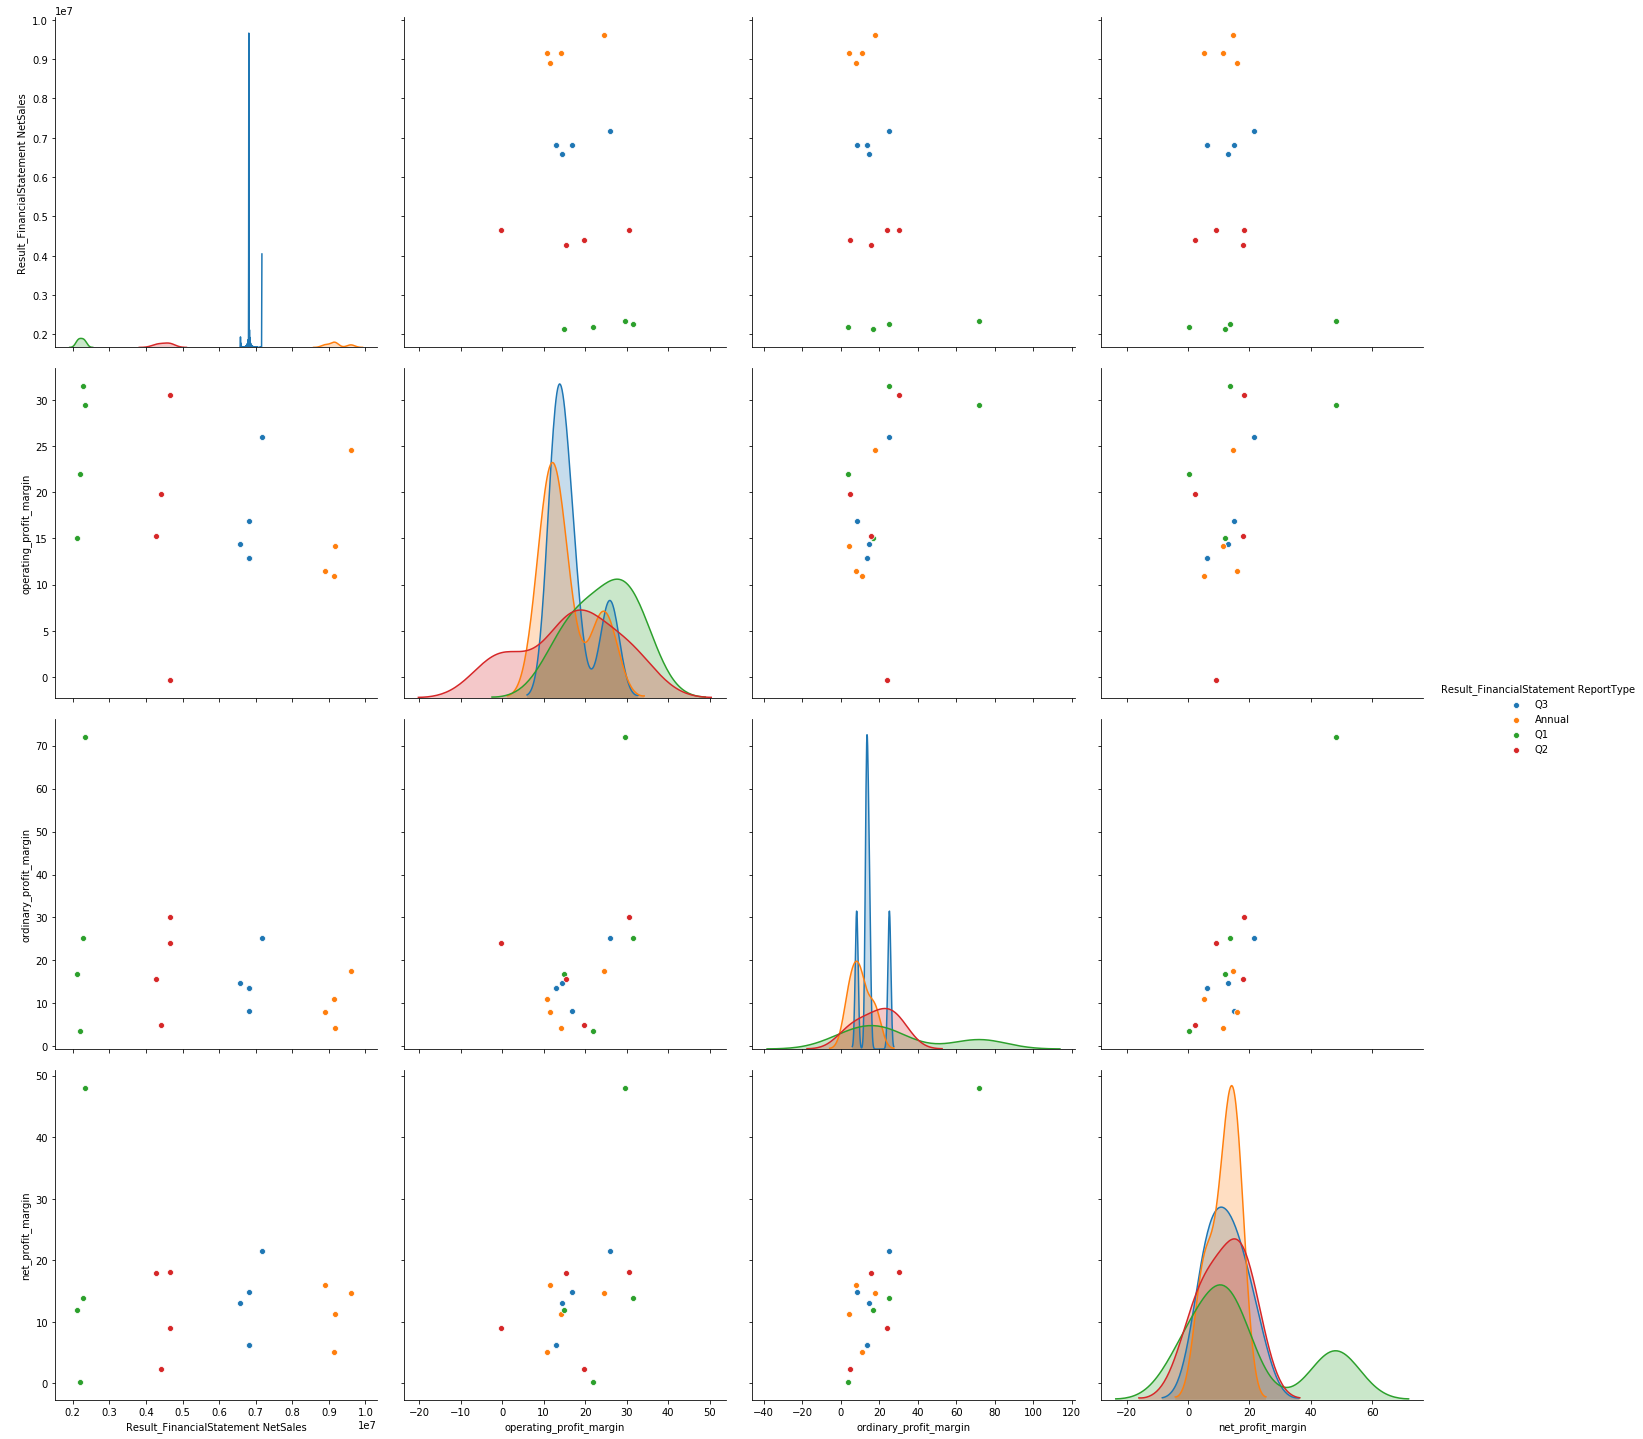

In [20]:
# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    #"Result_FinancialStatement OperatingIncome",  # 営業利益
    #"Result_FinancialStatement NetIncome",  # 純利益
    #"Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType", # 決算期
    #"Result_FinancialStatement CashFlowsFromOperatingActivities", # 営業キャッシュフロー
    #"Result_FinancialStatement CashFlowsFromFinancingActivities", # 財務キャッシュフロー
    #"Result_FinancialStatement CashFlowsFromInvestingActivities" # 投資キャッシュフロー
    "operating_profit_margin", # 売上高営業利益率
    "ordinary_profit_margin", # 売上高経常利益率　
    "net_profit_margin", # 売上高純履歴率
    #"total_asset_turnover",# 総資本回転率
    #"net_sales_growth_rate", # 売上高増加率
    #"ordinary_income_growth_rate", # 経常利益増加率
    #"operationg_income_growth_rate",# 営業利益増加率
    # "total_assets_growth_rate", # 総資本増加率
    #"net_assets_growth_rate"# 純資本増加率
]
fin_data = fin_data.fillna(0)
# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

In [21]:
fin_data[columns]

,Result_FinancialStatement NetSales,Result_FinancialStatement ReportType,operating_profit_margin,ordinary_profit_margin,net_profit_margin
datetime,,,,,
2016-02-10,6810206.0,Q3,12.853091,13.482911,6.298958
2016-04-21,6810206.0,Q3,12.853091,13.482911,6.298958
2016-05-10,9153549.0,Annual,10.919131,10.987694,5.180198
2016-07-28,2126521.0,Q1,15.012125,16.757935,11.951775
2016-11-07,4271834.0,Q2,15.308273,15.581715,17.937237
2017-02-08,6581466.0,Q3,14.429308,14.818234,13.027964
2017-05-10,8901004.0,Annual,11.526778,8.005007,16.024125
2017-08-07,2186059.0,Q1,21.924065,3.548303,0.252555
2017-11-06,4411135.0,Q2,19.832515,4.965185,2.326431


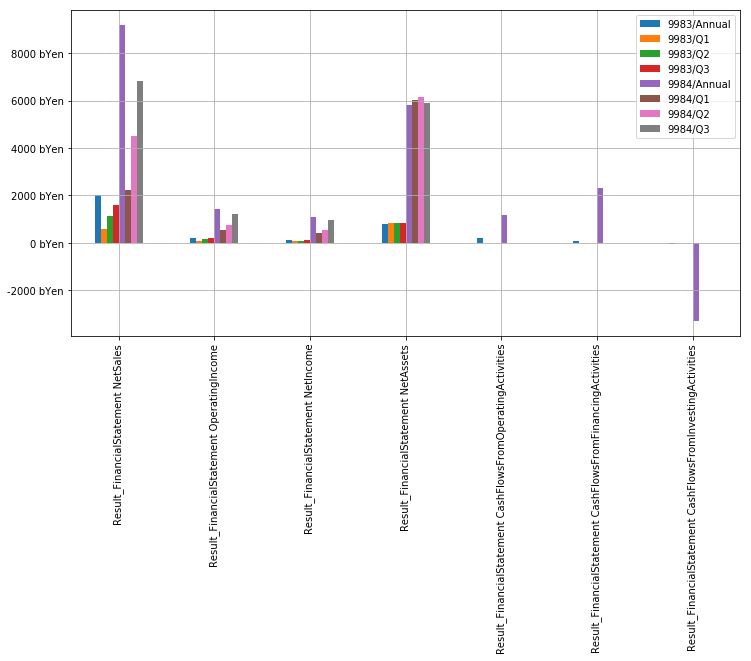

In [24]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType",  # 決算期
    "Result_FinancialStatement CashFlowsFromOperatingActivities", # 営業キャッシュフロー
    "Result_FinancialStatement CashFlowsFromFinancingActivities", # 財務キャッシュフロー
    "Result_FinancialStatement CashFlowsFromInvestingActivities" # 投資キャッシュフロー
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    fin_data.loc[:, "datetime"] = pd.to_datetime(fin_data["base_date"])
    fin_data.set_index("datetime", inplace=True)
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"]
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

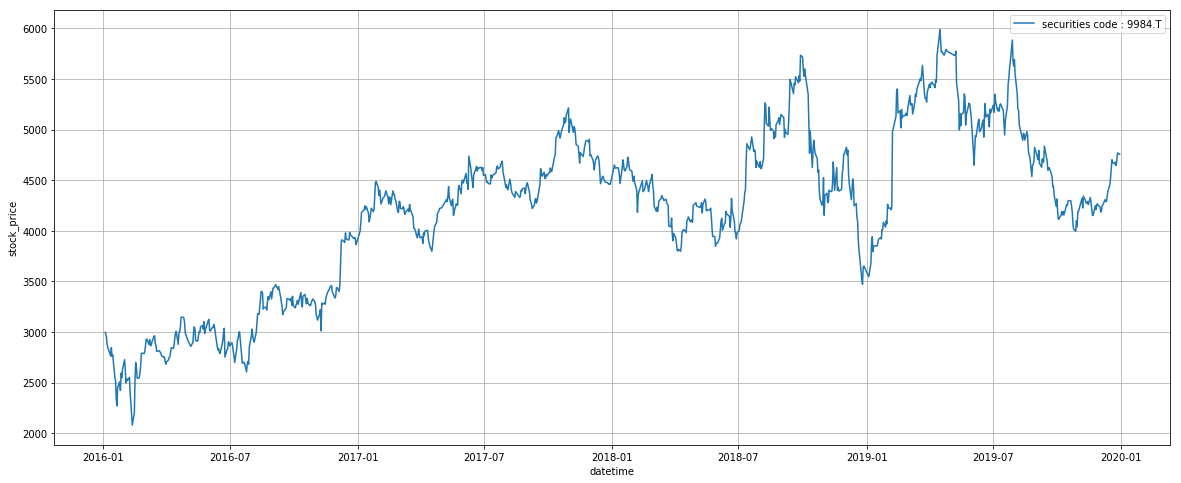

In [7]:
# stock_priceの読み込み
price = dfs["stock_price"].copy()

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
price_data = price_data[:"2019"]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

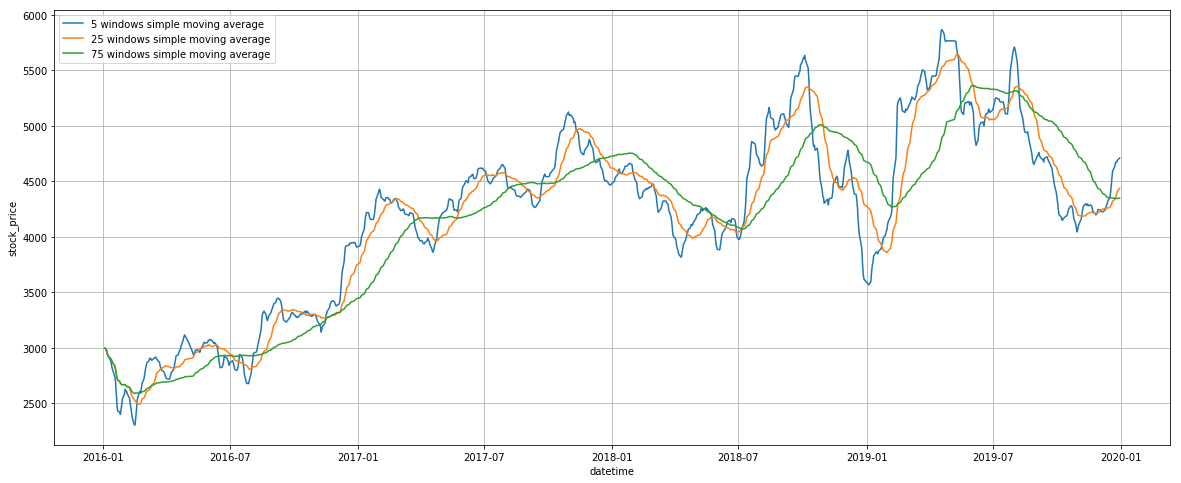

In [8]:
# stock_priceの読み込み
price = dfs["stock_price"].copy()

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
price_data = price_data[:"2019"]

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

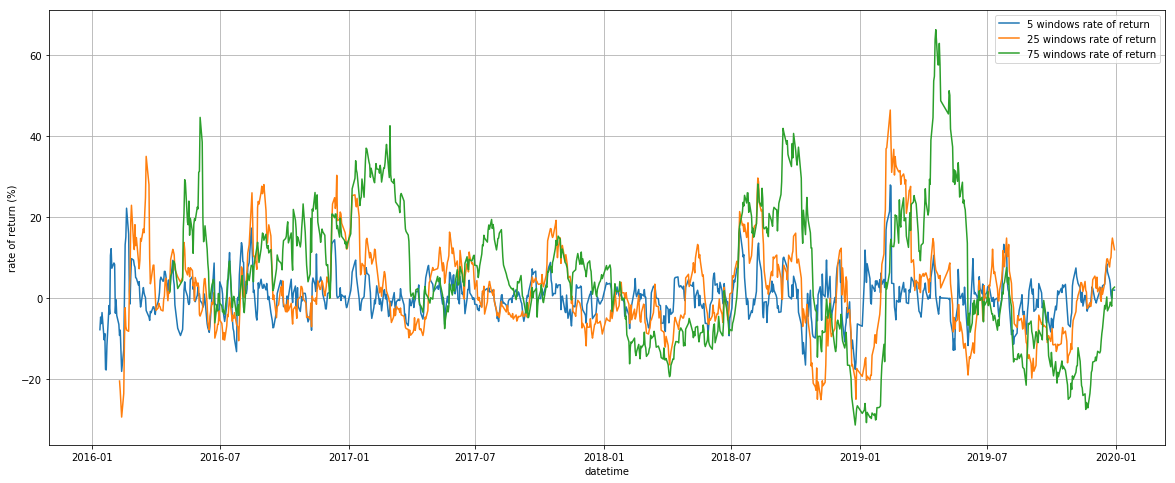

In [9]:
# stock_priceの読み込み
price = dfs["stock_price"].copy()

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
price_data = price_data[:"2019"]

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

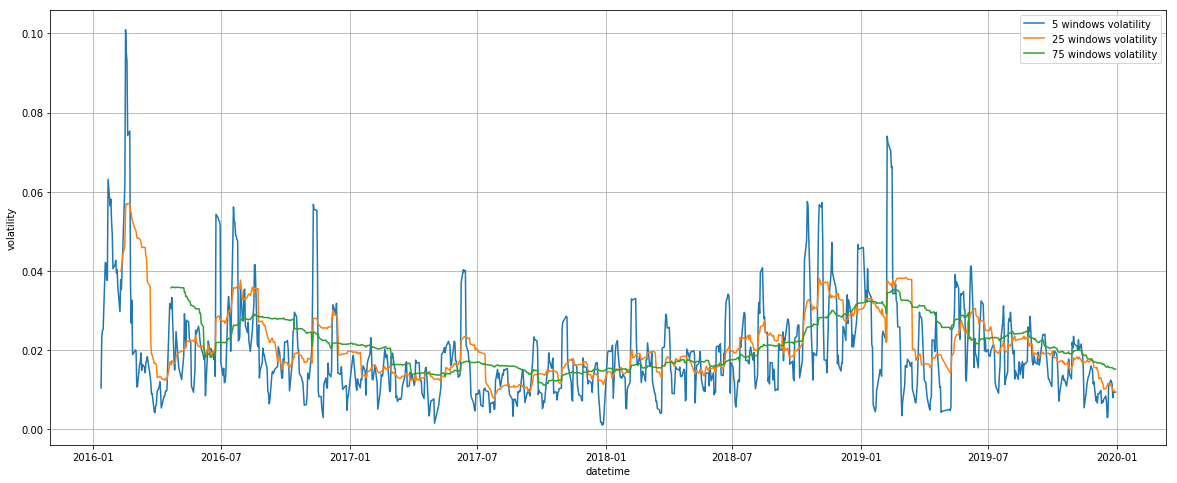

In [10]:
# stock_priceの読み込み
price = dfs["stock_price"].copy()

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
price_data = price_data[:"2019"]
# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

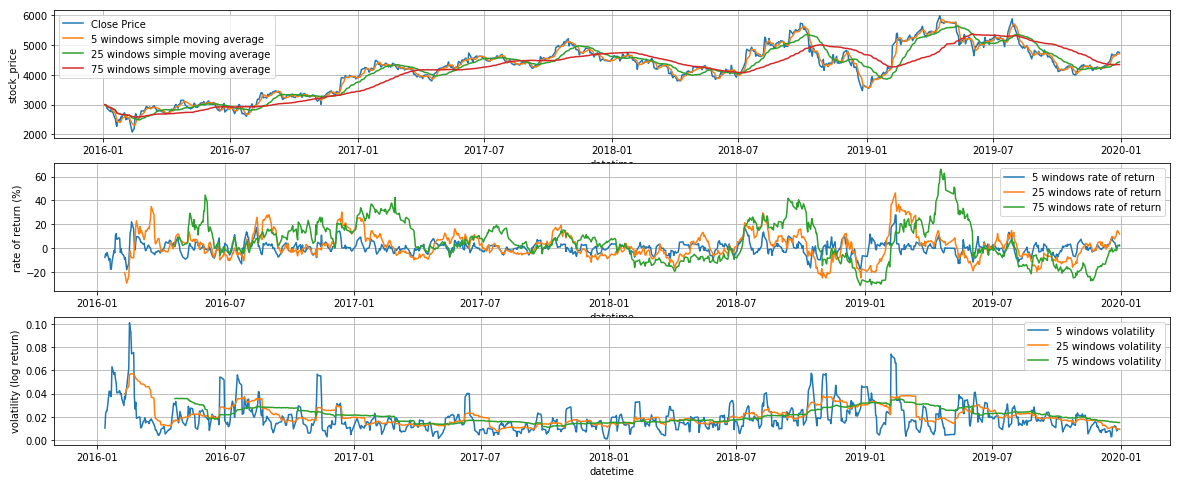

In [11]:
# stock_priceの読み込み
price = dfs["stock_price"].copy()

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
price_data = price_data[:"2019"]
# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

# 欠損値処理

(64421, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets 

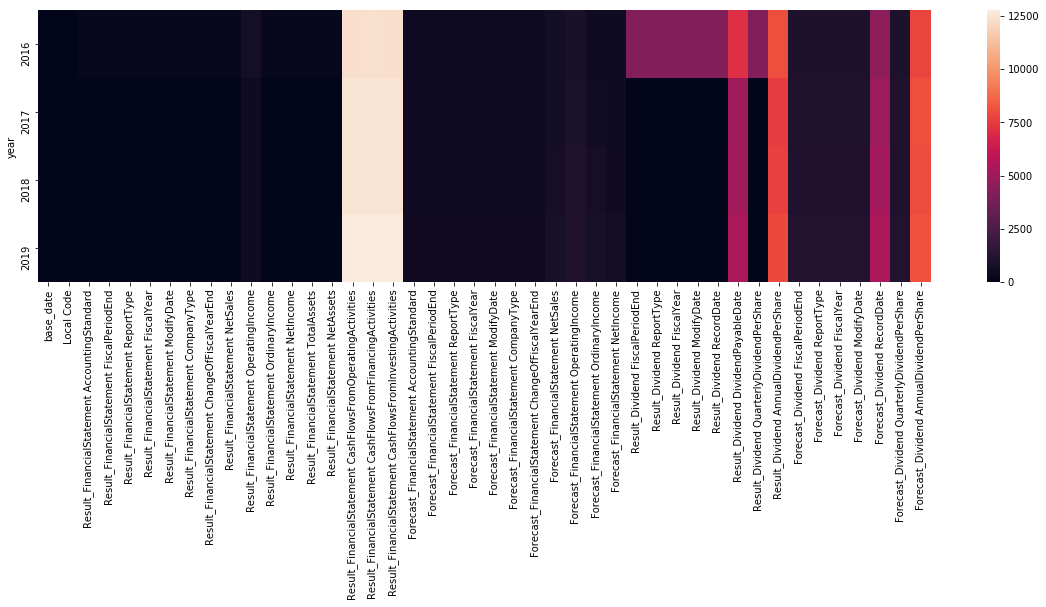

In [12]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
stock_fin["datetime"] = pd.to_datetime(stock_fin["base_date"])
stock_fin.set_index("datetime", inplace=True)
# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [13]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
stock_fin = stock_fin[stock_fin["Local Code"] == code]

# 日付列をpd.Timestamp型に変換してindexに設定
stock_fin["datetime"] = pd.to_datetime(stock_fin["base_date"])
stock_fin.set_index("datetime", inplace=True)

# float64型の列に絞り込み
fin_data = stock_fin.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

# 特徴量の生成

In [26]:
# stock_priceデータを読み込む
price = dfs["stock_price"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["Local Code"] == code].copy()
# 日付列をpd.Timestamp型に変換してindexに設定
price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
price_data.set_index("datetime", inplace=True)

In [27]:
# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()

In [28]:
# EWMA
ALPHA = 0.25
feats['EWMA'] = feats['EndOfDayQuote ExchangeOfficialClose']

for t in zip(feats.index, feats.index[1:]):
    feats.loc[t[1], 'EWMA'] = ALPHA * feats.loc[t[1], 'EndOfDayQuote ExchangeOfficialClose'] + (1 - ALPHA) * feats.loc[t[0], 'EWMA']

In [29]:
# EMA 10日
feats["ema_10"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=10).mean()

In [32]:
# MACD 
# EMA12
feats["ema_12"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=12).mean()
# EMA 26
feats["ema_26"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=26).mean()
feats["macd"] = feats["ema_12"] - feats["ema_26"]
feats["signal"] = feats["macd"].ewm(span=9).mean()

In [14]:
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)
# 元データのカラムを削除
feats = feats.dropna().drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

In [37]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

In [38]:
def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"].copy()

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
    fin_data.set_index("datetime", inplace=True)
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"].copy()
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
    price_data.set_index("datetime", inplace=True)
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )
    # EWMA
    ALPHA = 0.25
    feats['EWMA'] = feats['EndOfDayQuote ExchangeOfficialClose']

    for t in zip(feats.index, feats.index[1:]):
        feats.loc[t[1], 'EWMA'] = ALPHA * feats.loc[t[1], 'EndOfDayQuote ExchangeOfficialClose'] + (1 - ALPHA) * feats.loc[t[0], 'EWMA']
    
    # EMA 10日
    feats["ema_10"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=10).mean()
    
    # MACD 
    # EMA12
    feats["ema_12"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=12).mean()
    # EMA 26
    feats["ema_26"] = feats["EndOfDayQuote ExchangeOfficialClose"].ewm(span=26).mean()
    feats["macd"] = feats["ema_12"] - feats["ema_26"]
    feats["signal"] = feats["macd"].ewm(span=9).mean()

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    return feats

In [39]:
df = get_features_for_predict(dfs, 9984)
df.T

datetime,2016-02-10 00:00:00,2016-04-21 00:00:00,2016-05-10 00:00:00,2016-07-28 00:00:00,2016-11-07 00:00:00,2017-02-08 00:00:00,2017-05-10 00:00:00,2017-08-07 00:00:00,2017-11-06 00:00:00,2018-02-07 00:00:00,2018-05-09 00:00:00,2018-08-06 00:00:00,2018-11-05 00:00:00,2019-02-06 00:00:00,2019-05-09 00:00:00,2019-08-07 00:00:00,2019-11-06 00:00:00,2020-02-12 00:00:00,2020-04-13 00:00:00,2020-04-30 00:00:00,2020-05-18 00:00:00,2020-08-11 00:00:00,2020-10-23 00:00:00,2020-11-09 00:00:00
return_1month,-1.913212e-01,8.908766e-02,8.688554e-02,-7.610193e-02,-3.968613e-02,2.224838e-02,8.804402e-02,9.961943e-03,8.356941e-02,-5.596001e-02,1.203510e-01,1.374653e-01,-2.102032e-01,8.878024e-02,5.914718e-02,-4.413740e-03,4.902913e-02,1.390374e-01,1.158342e-01,2.606803e-01,4.547511e-02,1.112701e-02,1.489293e-01,1.229098e-02
return_2month,0.000000e+00,1.441458e-01,2.409844e-02,-1.417147e-01,-7.741374e-02,1.144764e-01,4.466859e-02,-4.780498e-02,1.592260e-01,-6.940874e-02,7.893497e-03,1.775059e-01,-1.119797e-01,-1.097317e-01,1.015737e-01,1.675649e-02,-8.101212e-02,3.389988e-01,-2.304874e-01,-8.942610e-02,2.591281e-01,2.268081e-01,6.656627e-02,2.476660e-01
return_3month,0.000000e+00,2.555166e-01,1.739812e-01,-1.038744e-01,6.066667e-02,4.418064e-01,-3.892833e-03,4.227793e-02,1.126650e-01,-1.333666e-01,-1.530847e-02,1.065103e-01,-1.693257e-01,-3.258260e-02,3.665405e-01,3.811906e-02,-1.688462e-01,3.455779e-01,-1.564571e-01,2.409372e-02,-1.624071e-01,4.041943e-01,6.576373e-02,1.438953e-01
volatility_1month,4.402584e-02,1.717726e-02,2.271106e-02,3.175834e-02,1.816612e-02,1.522609e-02,1.157811e-02,1.171816e-02,1.838358e-02,1.995841e-02,1.387375e-02,2.234456e-02,4.054193e-02,1.672133e-02,1.514235e-02,2.397602e-02,1.696050e-02,3.441563e-02,8.639982e-02,3.362599e-02,2.807880e-02,2.506267e-02,1.671309e-02,2.384297e-02
volatility_2month,0.000000e+00,1.705030e-02,1.818629e-02,3.062359e-02,1.717361e-02,1.409169e-02,1.290494e-02,1.194563e-02,1.601125e-02,1.687287e-02,1.634615e-02,2.083745e-02,3.290983e-02,2.824798e-02,1.593598e-02,2.228841e-02,1.804909e-02,2.717941e-02,6.703024e-02,6.833698e-02,6.368045e-02,2.546068e-02,2.740215e-02,2.594448e-02
volatility_3month,0.000000e+00,3.428422e-02,3.271347e-02,2.758085e-02,1.972693e-02,1.948615e-02,1.331634e-02,1.679778e-02,1.444113e-02,1.580369e-02,1.608024e-02,1.943844e-02,2.879765e-02,2.756937e-02,2.729567e-02,2.419688e-02,1.791320e-02,2.312453e-02,5.856385e-02,6.008750e-02,5.734101e-02,2.369026e-02,2.694665e-02,2.668409e-02
MA_gap_1month,9.107187e-01,1.071322e+00,1.008618e+00,9.588478e-01,9.694274e-01,1.012936e+00,1.066627e+00,9.912226e-01,9.996080e-01,9.540805e-01,1.044586e+00,1.007283e+00,9.445341e-01,1.052259e+00,1.014114e+00,9.641599e-01,1.033230e+00,1.196816e+00,1.109218e+00,1.066639e+00,1.010287e+00,9.711673e-01,1.026183e+00,1.015520e+00
MA_gap_2month,0.000000e+00,1.067462e+00,1.037082e+00,9.375874e-01,9.660428e-01,1.050702e+00,1.070177e+00,9.902299e-01,1.054210e+00,9.530104e-01,1.043655e+00,1.074974e+00,8.712824e-01,1.046151e+00,1.043537e+00,9.861688e-01,9.938260e-01,1.218323e+00,9.579964e-01,1.119096e+00,1.100513e+00,1.052475e+00,1.073177e+00,1.051756e+00
MA_gap_3month,0.000000e+00,1.110128e+00,1.066974e+00,9.219905e-01,9.633156e-01,1.115042e+00,1.051330e+00,1.002253e+00,1.079846e+00,9.376535e-01,1.019751e+00,1.101696e+00,8.690109e-01,1.006648e+00,1.073046e+00,9.971634e-01,9.581661e-01,1.260576e+00,9.266409e-01,1.031623e+00,1.043319e+00,1.123141e+00,1.079417e+00,1.073711e+00
EWMA,2.459623e+03,2.970546e+03,2.968909e+03,2.707878e+03,3.216363e+03,4.336250e+03,4.259626e+03,4.485870e+03,5.049587e+03,4.406237e+03,4.225049e+03,4.670359e+03,4.372986e+03,4.180759e+03,5.759659e+03,5.388780e+03,4.212239e+03,5.061225e+03,4.120243e+03,4.547565e+03,4.605597e+03,6.563248e+03,7.087225e+03,6.861518e+03


In [18]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"].copy()
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]
        # 日付列をpd.Timestamp型に変換してindexに設定
        stock_labels["datetime"] = pd.to_datetime(stock_labels["base_date"])
        stock_labels.set_index("datetime", inplace=True)

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END].copy()
            _val_X = feats[VAL_START : VAL_END].copy()
            _test_X = feats[TEST_START :].copy()

            _train_y = labels[: TRAIN_END].copy()
            _val_y = labels[VAL_START : VAL_END].copy()
            _test_y = labels[TEST_START :].copy()

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [19]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)


datetime                                              2016-02-10    2016-04-21    2016-05-10    2016-07-28  \
return_1month                                      -1.913212e-01  8.908766e-02  8.688554e-02 -7.610193e-02   
return_2month                                       0.000000e+00  1.441458e-01  2.409844e-02 -1.417147e-01   
return_3month                                       0.000000e+00  2.555166e-01  1.739812e-01 -1.038744e-01   
volatility_1month                                   4.402584e-02  1.717726e-02  2.271106e-02  3.175834e-02   
volatility_2month                                   0.000000e+00  1.705030e-02  1.818629e-02  3.062359e-02   
volatility_3month                                   0.000000e+00  3.428422e-02  3.271347e-02  2.758085e-02   
MA_gap_1month                                       9.107187e-01  1.071322e+00  1.008618e+00  9.588478e-01   
MA_gap_2month                                       0.000000e+00  1.067462e+00  1.037082e+00  9.375874e-01   
MA_gap_3m

In [20]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [21]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

In [27]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# Submit Model

In [29]:
model_path = os.path.join(os.path.dirname("__file__"), "archive/model")
# tag::save_model[]
# モデル保存先ディレクトリを作成
os.makedirs(model_path, exist_ok=True)
with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
    # モデルをpickle形式で保存
    pickle.dump(model, f)


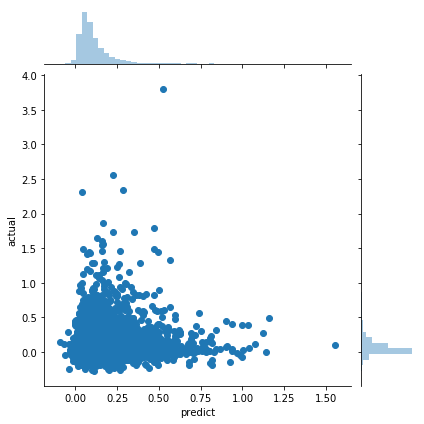

In [30]:
sns.jointplot(data=result[label], x="predict", y="actual")

Text(0.5, 0, 'Random Forest Feature Importance')

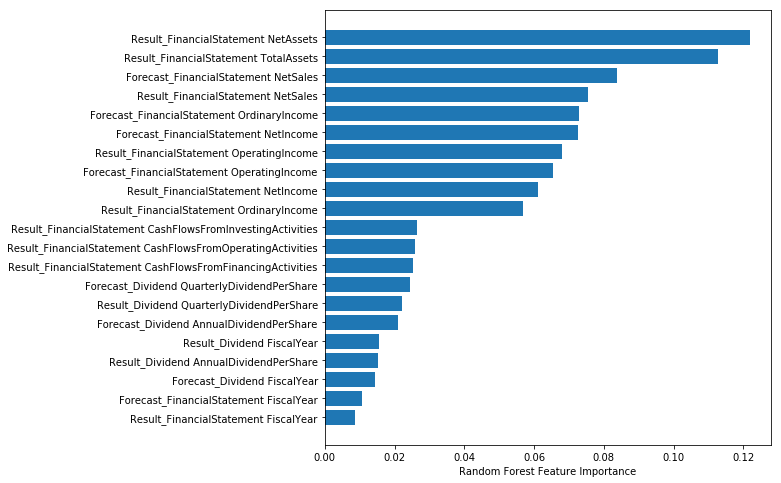

In [32]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

In [33]:
# モデルを定義します
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

model_output = "margin" has been renamed to model_output = "raw"


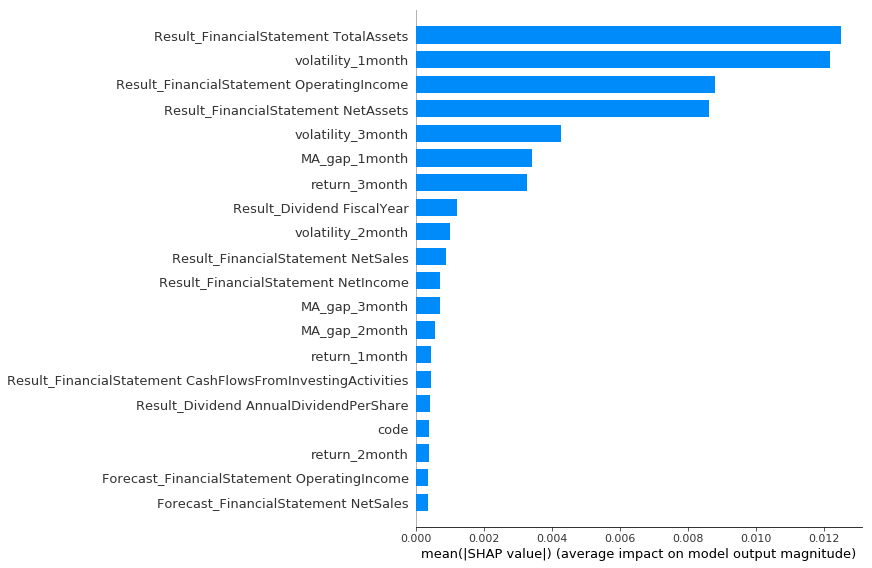

In [34]:
shap.initjs()
explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X["label_high_20"])
# プロット
shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")

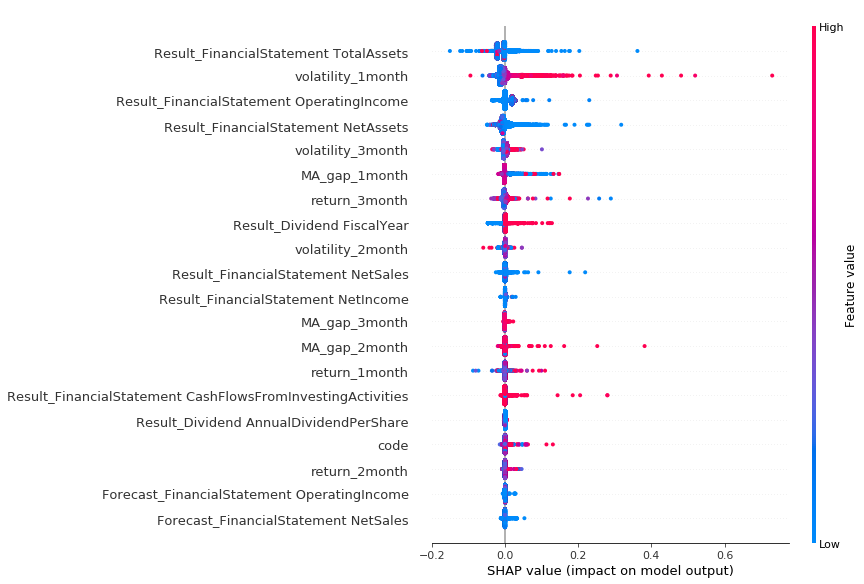

In [35]:
shap.summary_plot(shap_values, train_X["label_high_20"])

In [36]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    # データセット毎に処理
    for col in columns.keys():
        result = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# --------------------------------------------------------------------------------------

In [1]:
with open('all_results', mode='rb') as f:
    all_results = pickle.load(f)

NameError: name 'pickle' is not defined

In [ ]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

In [9]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="../data_dir"

In [10]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


In [14]:
# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

NameError: name 'train_X' is not defined

In [12]:
# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

NameError: name 'returns_cols' is not defined

In [5]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
for feature in columns:
    matrix = dict()
    # モデル毎に処理
    for model in models:
        # 目的変数毎に処理
        for label in labels:
            # 処理対象データに絞り込み
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            # RMSE
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            # 精度
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            # 相関係数
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            # 順位相関
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            # 結果を保存
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

NameError: name 'columns' is not defined